In [1]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"

In [2]:
from transformers import AutoModelForCausalLM

model_pt = AutoModelForCausalLM.from_pretrained(
    '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/',
    trust_remote_code=True, torch_dtype="auto", device_map='meta',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

/home/galqiwi/miniconda-eval/envs/eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████████████| 4/4 [00:00<00:00,  6.23it/s]


In [3]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [4]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [21]:
data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')

data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

In [22]:
layers = sorted(set(data_df['layer']))
len(layers)

224

In [34]:
from scipy.stats import linregress


scale_by_layer = {}
intercept_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    linreg = linregress(to_fit['mse'], to_fit['wikitext2'])
    
    scale_by_layer[layer] = linreg.slope
    intercept_by_layer[layer] = linreg.intercept

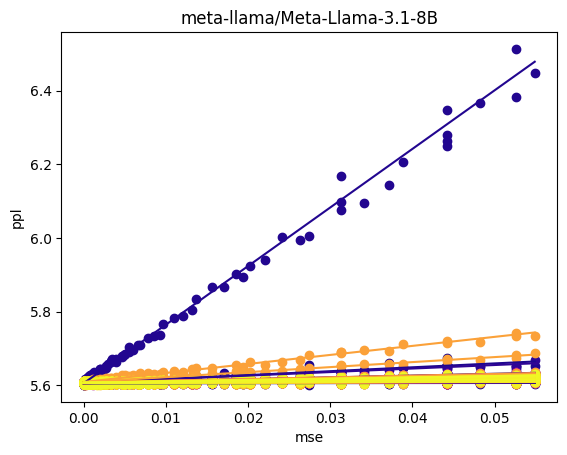

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer'] == layer]
    to_plot = to_plot[to_plot['mse'] < 4 ** -2]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(to_plot['mse'].min(), to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercept_by_layer[layer] + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [45]:
pd.DataFrame(scale_by_layer.items()).sort_values(1).tail(20)

,0,1
46,model.layers.14.self_attn.o_proj,0.393053
170,model.layers.30.mlp.up_proj,0.400046
105,model.layers.22.mlp.down_proj,0.402056
25,model.layers.11.self_attn.o_proj,0.405145
91,model.layers.20.mlp.down_proj,0.409118
176,model.layers.31.mlp.gate_proj,0.411742
49,model.layers.15.mlp.down_proj,0.418914
77,model.layers.19.mlp.down_proj,0.419792
56,model.layers.16.mlp.down_proj,0.422843
98,model.layers.21.mlp.down_proj,0.435754


In [ ]:

ΩΩ

In [41]:
import json

with open('scales.json', 'w') as file:
    json.dump(scale_by_layer, file)

In [25]:
pd.DataFrame(scale_by_layer.items(), columns=['layer', 'scale']).sort_values('scale')

,layer,scale
5,model.layers.0.self_attn.q_proj,0.010174
3,model.layers.0.self_attn.k_proj,0.016067
108,model.layers.22.self_attn.k_proj,0.028611
173,model.layers.30.self_attn.q_proj,0.036338
129,model.layers.25.self_attn.k_proj,0.044238
...,...,...
13,model.layers.1.self_attn.v_proj,0.956345
6,model.layers.0.self_attn.v_proj,1.057290
177,model.layers.31.mlp.up_proj,1.360917
175,model.layers.31.mlp.down_proj,2.451660


In [26]:
methods_list = []

methods_list.append({
    'bits': 16,
    'mse': 0,
    'name': 'fp16',
})

methods_list.append({
    'bits': 8,
    'mse': 4 ** -8,
    'name': 'int8',
})

methods_list.append({
    'bits': 4,
    'mse': 4 ** -4,
    'name': 'fp4',
})

methods_df = pd.DataFrame(configs_list)

NameError: name 'configs_list' is not defined

In [ ]:
def prune_unoptimal(configurations):
    configurations = sorted(configurations, key=lambda conf: conf['bits'])
    
    output = []
    best_err = float('+inf')

    for conf in configurations:
        conf_err = conf['sum_err']
        if conf_err >= best_err:
            continue

        best_err = conf_err
        output.append(conf)

    return output


def update_optimal_configurations(optimal_configurations, err_slope, methods_df, numel):
    configurations = []

    for _, method in methods_df.iterrows():
        for conf in optimal_configurations:
            configurations.append({
                'bits': conf['bits'] + method['bits'] * numel,
                'sum_err': conf['sum_err'] + method['mse'] * err_slope,
                'names': conf['names'] + (method['name'],)
            })

    return prune_unoptimal(configurations)


def get_optimal_configurations(scale_by_layer, methods_df):
    # important: lexicographic sort, not numerical
    layers = set(scale_by_layer.keys())
    layers = [
        layer for
        layer, _ in
        sorted(scale_by_layer.items(), key=lambda x: x[1])
    ]
    # assert set(layers) == set(scale_by_layer.keys())
    
    output = [{
        'bits': 0.0,
        'sum_err': 0.0,
        'names': tuple(),
    }]

    for layer in tqdm.tqdm(layers):
        output = update_optimal_configurations(output, scale_by_layer[layer], methods_df, get_numel(layer))
        while len(output) > 1000:
            output = output[::2]
    
    return layers, output

In [263]:
layers, optimal_configs = get_optimal_configurations(scale_by_layer, )

100%|█████████████████████████████████████████| 224/224 [00:33<00:00,  6.63it/s]


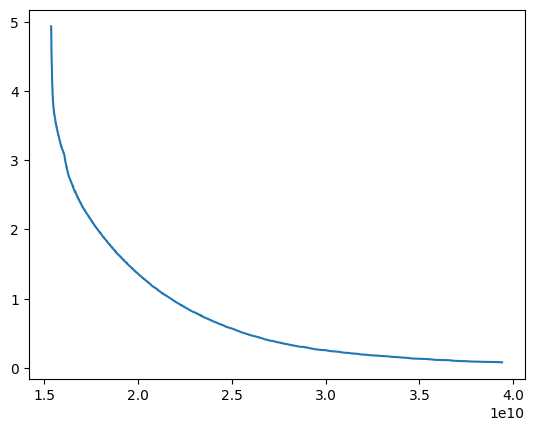

In [266]:
plt.plot([conf['bits'] for conf in optimal_configs], [conf['sum_err'] for conf in optimal_configs])

In [280]:
optimal_conf = max(filter(lambda conf: conf['bits'] < 3 * total_params, optimal_configs), key=lambda conf: conf['bits'])

In [286]:
optimal_conf['bits'] / total_params

2.996862597809077

In [282]:
optimal_by_layer = dict(zip(layers, optimal_conf['names']))

In [283]:
layer_idx = 0

def to_list(name):
    return [round(float(x.split('=')[-1])) for x in name.split(';')]

output = []

for layer_idx in range(32):
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.q_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.k_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.v_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.o_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.gate_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.up_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.down_proj']))

print(output)

[[5, 2048], [5, 4096], [2, 4096], [3, 2048], [5, 2048], [5, 4096], [3, 2048], [4, 2048], [3, 2048], [1, 32], [3, 2048], [5, 4096], [3, 256], [2, 4096], [4, 4096], [3, 2048], [1, 64], [4, 4096], [4, 2048], [4, 4096], [4, 2048], [3, 512], [3, 4096], [2, 1024], [3, 2048], [4, 2048], [4, 2048], [3, 512], [4, 4096], [3, 2048], [2, 1024], [3, 2048], [4, 2048], [4, 4096], [4, 4096], [3, 512], [3, 2048], [3, 4096], [3, 2048], [3, 256], [4, 4096], [3, 256], [4, 4096], [3, 4096], [3, 4096], [3, 1024], [4, 2048], [4, 4096], [4, 2048], [2, 128], [3, 2048], [1, 32], [2, 128], [4, 2048], [3, 256], [2, 64], [3, 1024], [1, 16], [2, 1024], [3, 2048], [5, 4096], [4, 2048], [4, 2048], [3, 1024], [3, 4096], [3, 4096], [2, 256], [5, 4096], [4, 2048], [4, 2048], [3, 2048], [3, 2048], [2, 4096], [3, 4096], [5, 4096], [4, 2048], [3, 256], [3, 2048], [3, 4096], [2, 4096], [3, 4096], [5, 4096], [4, 2048], [4, 2048], [3, 512], [3, 2048], [2, 4096], [2, 256], [4, 2048], [3, 512], [4, 4096], [3, 2048], [3, 4096], 

In [223]:
len(output)

224

In [27]:
!git add . && git commit -m 'linear-layer-compression' && git push

[galqiwi 085d547] linear-layer-compression
 2 files changed, 1543 insertions(+)
 create mode 100644 Vladimir/2024-09-03/lienar-layer-compression/.ipynb_checkpoints/values-checkpoint.ipynb
 create mode 100644 Vladimir/2024-09-03/lienar-layer-compression/values.ipynb
Counting objects: 7, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 55.98 KiB | 14.00 MiB/s, done.
Total 7 (delta 0), reused 0 (delta 0)
To github.com:galqiwi/linear-layer-compression.git
   bf437c9..085d547  galqiwi -> galqiwi
